# Lab Part A

## Settings

In [89]:
import math
import numpy as np
from matplotlib import pyplot as plt

Our goal is to model a hill by superimposing a uniform flow with a source flow. To achieve this, we'll visualize the streamlines resulting from their combination. This requires first defining a grid of points where the velocity components will be calculated.

Let's define an evenly spaced Cartesian grid of points within a spatial domain that is 100 units of length wide in the $x$-direction, and 63 units of length wide in the $y$-direction, i.e. $x,y\in\left[-50,50\right],\left[-3,60\right]$.

The variable N will be the number of points we want in each direction, and we define the computational boundaries by the variables x_start, x_end, y_start and y_end.
We use the NumPy function linspace() to create two 1D arrays that contain the evenly spaced values of 
and coordinates, corresponding to our grid points. The last line of the code block below calls the meshgrid() function, which generates arrays containing the coordinates of points where the numerical solution will be calculated. 

In [90]:
N = 300                              # Number of points in each direction
x_start, x_end = -50.0, 50.0            # x-direction boundaries
y_start, y_end = -3.0, 60.0            # y-direction boundaries
x = np.linspace(x_start, x_end, N)    # 1D-array for x
y = np.linspace(y_start, y_end, N)    # 1D-array for y
X, Y = np.meshgrid(x, y)              # generates a mesh grid

## Source in a uniform flow

### Freesream

The streamlines of a freestream with speed $U_\infty$ and angle of attack $\alpha$ are given by:

$$\psi_\text{freestream}\left(x,y\right) = U_\infty \left(y\cos\alpha - x\sin\alpha\right)$$

Think about it: the streamlines are all straight, parallel lines that make an angle $\alpha$ with the $x$-axis. If the flow is completely horizontal, $\psi= U_\infty y$. Integrate, and you get that $u=U_\infty$ and $v=0$.
    
Let's write some code that will fill the arrays containing the $u$-velocity, the $v$-velocity and the stream function of a uniform horizontal flow $\left(U_\infty,\alpha=0\right)$, on every point of our grid. Note the handy NumPy functions [`ones()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ones.html), which creates a new array and fills it up with the value 1 everywhere, and `zeros()` creates a new array and fills it up with the value 0 everywhere.

In [91]:
u_inf = 20.0        # freestream speed

# compute the freestream velocity field
u_freestream = u_inf * np.ones((N, N), dtype=float)
v_freestream = np.zeros((N, N), dtype=float)

# compute the stream-function
psi_freestream = u_inf * Y

### Source flow

Notice how we calculated all the values of `psi_freestream` in one fell swoop? No need for those cumbersome double loops—and it turns out, when the arrays are big, this is a lot faster to compute! Thank you `Numpy`!

From our previous *AeroPython* notebook, the stream function of a source flow located at $\left(x_\text{source},y_\text{source}\right)$ is:

$$\psi_\text{source}\left(x,y\right) = \frac{\sigma}{2\pi} \arctan \left(\frac{y-y_\text{source}}{x-x_\text{source}}\right)$$

and the velocity components are:

$$u_\text{source}\left(x,y\right) = \frac{\sigma}{2\pi} \frac{x-x_\text{source}}{\left(x-x_\text{source}\right)^2 + \left(y-y_\text{source}\right)^2}$$

$$v_\text{source}\left(x,y\right) = \frac{\sigma}{2\pi} \frac{y-y_\text{source}}{\left(x-x_\text{source}\right)^2 + \left(y-y_\text{source}\right)^2}$$

And remember that the stream function and velocity field of a source and a sink are exactly the same except one has positive strength while the other has negative strength. 

We can write functions that serve a double purpose: with $\sigma$ positive, they give the velocity and stream function of a source; with $\sigma$ negative, they give them for a sink. Aren't we clever?

Let's define a function called `get_velocity()` to compute the velocity components $(u,v)$ on a mesh (`X`,`Y`), given the `strength` of the singularity and its location (`xs`,`ys`). We define it with the `def` command, followed by our chosen name for the function, and any parameters inside the parenthesis. The line ends with a colon:

In [92]:
def get_velocity(strength, xs, ys, X, Y):
    """
    Returns the velocity field generated by a source/sink.
    
    Parameters
    ----------
    strength: float
        Strength of the source/sink.
    xs: float
        x-coordinate of the source (or sink).
    ys: float
        y-coordinate of the source (or sink).
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    u = strength / (2 * np.pi) * (X - xs) / ((X - xs)**2 + (Y - ys)**2)
    v = strength / (2 * np.pi) * (Y - ys) / ((X - xs)**2 + (Y - ys)**2)
    
    return u, v

Note that the output of the function consists of two arrays: `u` and `v`. They are calculated inside the function, which is indicated by the indentation of the lines after the colon. The final line indicates with the `return` keyword that the arrays `u, v` are sent back to the statement that called the function.

Similarly, we define another function to compute the stream-function of the singularity (source or sink) on the mesh grid, and call it `get_stream_function()`.

In [93]:
def get_stream_function(strength, xs, ys, X, Y):
    """
    Returns the stream-function generated by a source/sink.
    
    Parameters
    ----------
    strength: float
        Strength of the source/sink.
    xs: float
        x-coordinate of the source (or sink).
    ys: float
        y-coordinate of the source (or sink).
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    psi: 2D Numpy array of floats
        The stream-function.
    """
    psi = strength / (2 * np.pi) * np.arctan2((Y - ys), (X - xs))
    
    return psi

#### Calculating source strength, velocity field and stream-function

Now let's calculate the desired source strength:  
We want $\psi(0,40) = 0$, as our source is located at the origin.  

$$
\psi = \psi_{\text{freestream}} + \psi_{\text{source}} 
= U_\infty y + \frac{\sigma}{2\pi} \arctan\left(\frac{y}{x}\right)
$$

$$
\arctan\left(\frac{y}{x}\right) 
= \arctan\left(\frac{40}{0^+}\right) 
= \arctan(\infty) 
= \frac{\pi}{2}
$$

$$
20 \times 40 = \frac{\sigma}{2\pi} \times \frac{\pi}{2} 
= \frac{\sigma}{4}
$$

$$
\sigma = 3200 \ \frac{m^2}{s}
$$


In [107]:
strength_source = 3200 # strength of the source
x_source, y_source = 0.0, 0.0   # location of the source

# compute the velocity field
u_source, v_source = get_velocity(strength_source, x_source, y_source, X, Y)

# compute the stream-function
psi_source = get_stream_function(strength_source, x_source, y_source, X, Y)

### Superposition (Uniform Flow + Source)

Let's again use our superposition powers. The streamlines of the combination of a freestream and a source flow are:

$$\psi = \psi_{freestream}+\psi_{source} = U_\infty y + \frac{\sigma}{2\pi} \arctan \left(\frac{y-y_\text{source}}{x-x_\text{source}}\right)$$

And since differentiation is linear, the velocity field induced by the new flow pattern is simply the sum of the freestream velocity field and the source velocity field:

$$u = u_\text{freestream} + u_\text{source}$$
$$v = v_\text{freestream} + v_\text{source}$$

The stagnation points in the flow are points where the velocity is zero (stagnant fluid, get it?). To find their location, we solve the following equations:

$$u = 0 , \quad v = 0$$

which leads to:

$$x_\text{stagnation} = x_\text{source} - \frac{\sigma}{2\pi U_\infty}$$

$$y_\text{stagnation} = y_\text{source}$$

The streamline containing the stagnation point is called the *dividing streamline*. It separates the fluid coming from the freestream and the fluid radiating from the source flow. On the streamline plot, we'll add a red curve to show the dividing streamline, and we'll use the [`contour()`](http://matplotlib.org/api/pyplot_api.html?highlight=contour#matplotlib.pyplot.contour) function for that. 

We will also draw a green circle to show the location of the stagnation point, red one to show the source flow origin at (0,0) and black one to show the top of the hill point at (0,40), using the [`scatter()`](http://matplotlib.org/api/pyplot_api.html?highlight=scatter#matplotlib.pyplot.scatter) function.

#### Streamline 

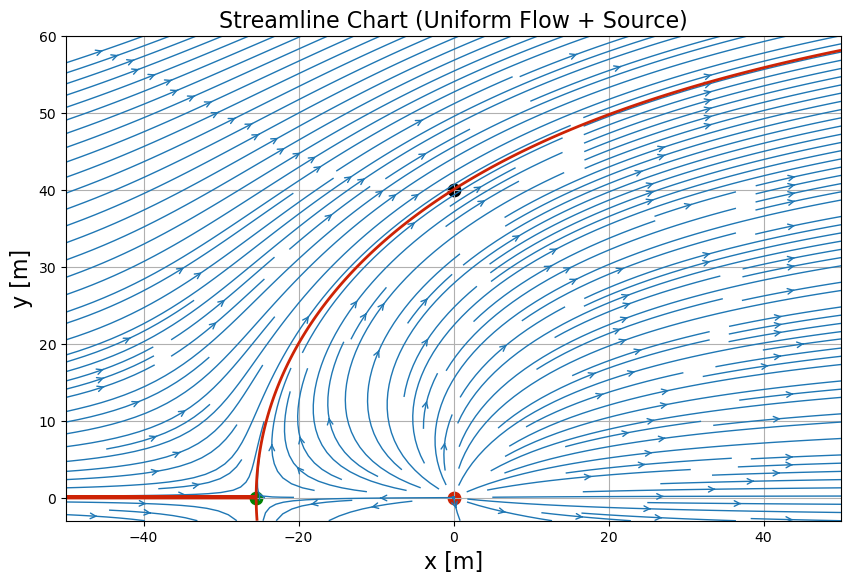

In [108]:
# superposition of the source on the freestream
u = u_freestream + u_source
v = v_freestream + v_source
psi = psi_freestream + psi_source

# plot the streamlines
width = 10
height = (y_end - y_start) / (x_end - x_start) * width
plt.figure(figsize=(width, height))
plt.title("Streamline Chart (Uniform Flow + Source)" ,fontsize=16)
plt.grid(True)
plt.xlabel('x [m]', fontsize=16)
plt.ylabel('y [m]', fontsize=16)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->')
plt.scatter(x_source, y_source, color='#CD2305', s=80, marker='o')

# calculate the stagnation point
x_stagnation = x_source - strength_source / (2 * np.pi * u_inf)
y_stagnation = y_source

# display the stagnation point
plt.scatter(x_stagnation, y_stagnation, color='g', s=80, marker='o')

plt.scatter(0,40,color='black',s=80)

# display the dividing streamline
plt.contour(X, Y, psi, 
               levels=[-strength_source / 2, strength_source / 2], 
               colors='#CD2305', linewidths=2, linestyles='solid');
plt.show()

#### Pressure coefficient

Now let's calculate the Pressure Coefficient field using the formula:

$$
C_p = 1 - \left( \frac{V}{U_\infty} \right)^2
$$

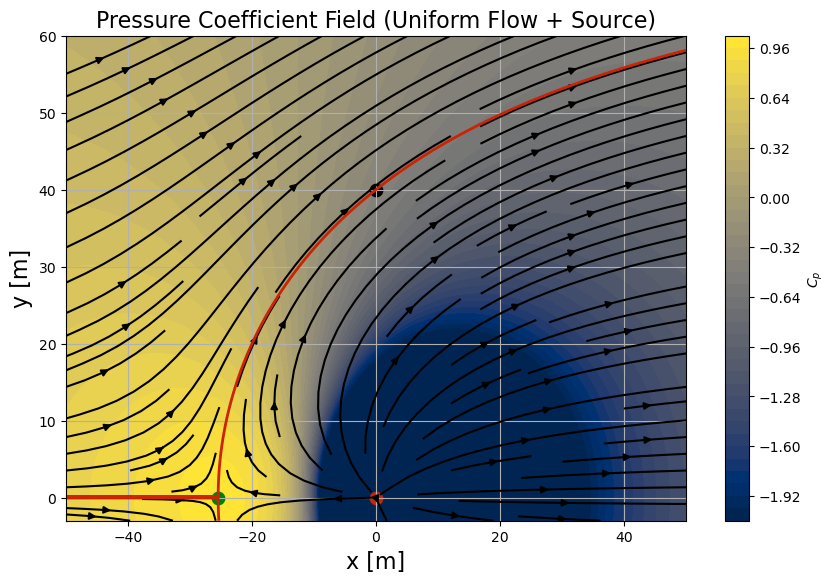

In [109]:
V = np.sqrt(u**2 + v**2)
V_abs_clipped = np.clip(V, 0, 35)
Cp = 1 - (V_abs_clipped / u_inf)**2

plt.figure(figsize=(width, height))
contour = plt.contourf(X, Y, Cp, levels=50, cmap='cividis')
plt.colorbar(contour, label=r"$C_p$")
plt.streamplot(X, Y, u, v, color='k', density=1)
plt.title("Pressure Coefficient Field (Uniform Flow + Source)",fontsize=16)
plt.xlabel("x [m]",fontsize=16)
plt.ylabel("y [m]",fontsize=16)
plt.axis([x_start, x_end, y_start, y_end])
plt.grid(True)
plt.scatter(x_source, y_source, color='#CD2305', s=80, marker='o')

# display the stagnation point
plt.scatter(x_stagnation, y_stagnation, color='g', s=80, marker='o')

plt.scatter(0,40,color='black',s=80)

# display the dividing streamline
plt.contour(X, Y, psi, 
               levels=[-strength_source / 2, strength_source / 2], 
               colors='#CD2305', linewidths=2, linestyles='solid');
plt.show()

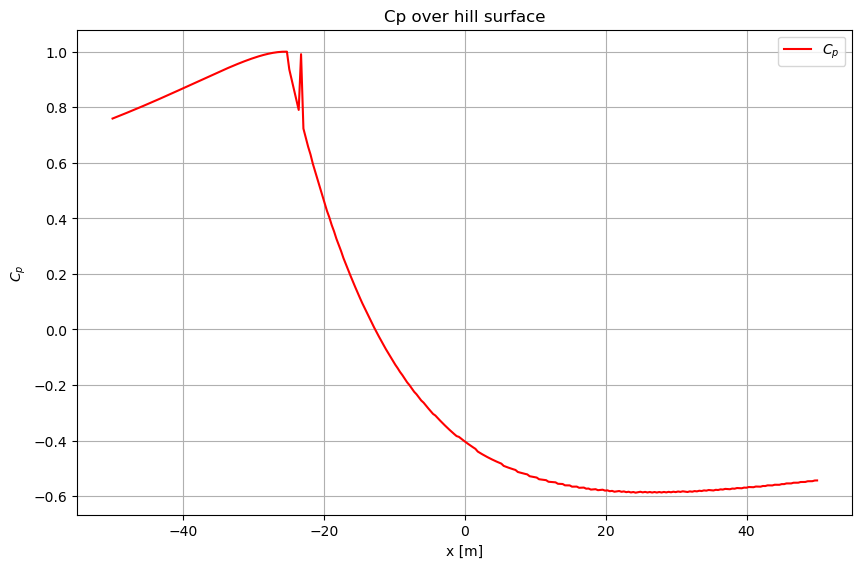

In [101]:
psi_surface = 1600

# Allocate arrays for output
y_hill = np.zeros_like(x)
Cp_surface = np.zeros_like(x)
V_surface = np.zeros_like(x)

# For each x column, find y where psi ≈ 1600
for i in range(len(x)):
    psi_col = psi[:, i]
    idx = np.argmin(np.abs(psi_col - psi_surface))  # closest y-index

    y_hill[i] = y[idx]
    Cp_surface[i] = Cp[idx, i]     # from precomputed Cp field
    V_surface[i] = V[idx, i]   # from velocity magnitude field

plt.figure(figsize=(width, height))
plt.plot(x, Cp_surface, label=r"$C_p$", color='red')
plt.xlabel("x [m]")
plt.ylabel(r"$C_p$")
plt.title("Cp over hill surface")
plt.grid(True)
plt.legend()
plt.show()

#### Velocity Field

Now let's create the velocity field using the formula:

$$
V = \sqrt{u^2 + v^2}
$$


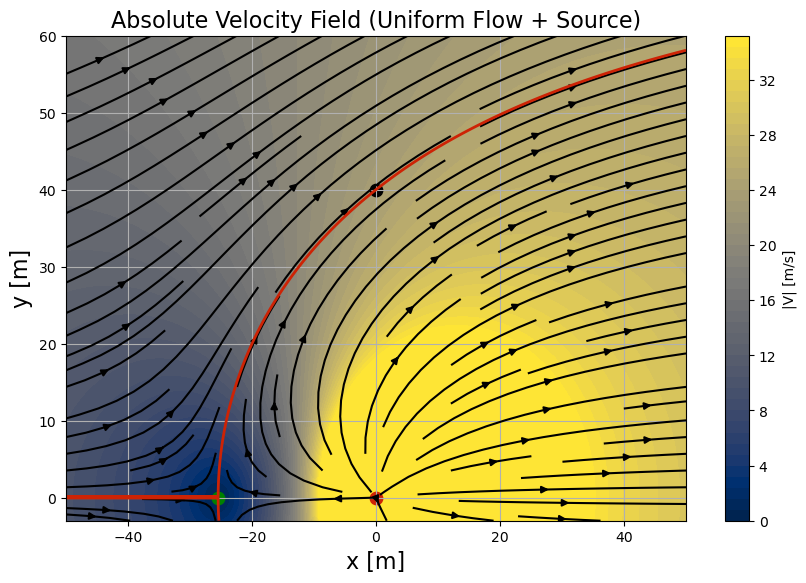

In [102]:
V = np.sqrt(u**2 + v**2)
V_abs_clipped = np.clip(V, 0, 35)

# plot the absolute velocity
plt.figure(figsize=(width, height))
contour = plt.contourf(X, Y, V_abs_clipped, levels=50, cmap='cividis')
plt.colorbar(contour, label='|V| [m/s]')
plt.streamplot(X, Y, u, v, color='k', density=1)
plt.title("Absolute Velocity Field (Uniform Flow + Source)",fontsize=16)
plt.xlabel("x [m]",fontsize=16)
plt.ylabel("y [m]",fontsize=16)
plt.axis([x_start, x_end, y_start, y_end])
plt.grid(True)
plt.scatter(x_source, y_source, color='#CD2305', s=80, marker='o')

# display the stagnation point
plt.scatter(x_stagnation, y_stagnation, color='g', s=80, marker='o')

plt.scatter(0,40,color='black',s=80)

# display the dividing streamline
plt.contour(X, Y, psi, 
               levels=[-strength_source / 2, strength_source / 2], 
               colors='#CD2305', linewidths=2, linestyles='solid');
plt.show()

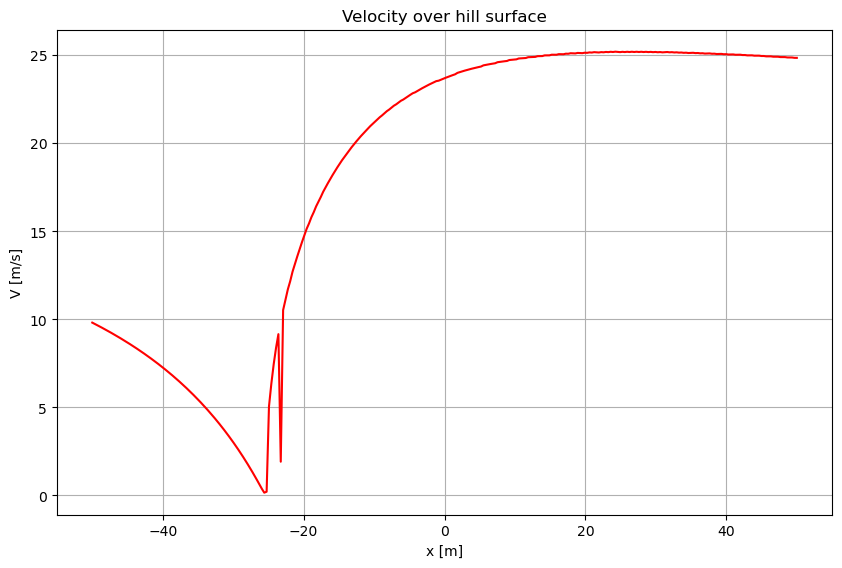

In [103]:
# Plot V vs x along the hill
plt.figure(figsize=(width, height))
plt.plot(x, V_surface, label=r"$V_{\mathrm{surface}}$", color='red')
plt.xlabel("x [m]")
plt.ylabel("V [m/s]")
plt.title("Velocity over hill surface")
plt.grid(True)
plt.legend
plt.show()

#### Comparing analytic solution to the numerical calculation

Let's calculate the velocity at $(0,40)$:

$$
\psi = \psi_{\text{freestream}} + \psi_{\text{source}} 
= U_\infty y + \frac{\sigma}{2\pi} \arctan\left(\frac{y}{x}\right)
$$

$$
u(x,y) = \frac{\partial \psi}{\partial y} 
= U_\infty + \frac{\sigma}{2\pi} \frac{x}{x^2 + y^2} 
= 20 + \frac{3200}{2\pi} \frac{0}{0^2 + 40^2} 
= 20 \ \frac{\text{m}}{\text{s}}
$$

$$
v(x,y) = -\frac{\partial \psi}{\partial x} 
= \frac{\sigma}{2\pi} \frac{y}{x^2 + y^2} 
= \frac{3200}{2\pi} \frac{40}{0^2 + 40^2} 
= 12.732 \ \frac{\text{m}}{\text{s}}
$$

$$
V = \sqrt{u^2 + v^2} 
= \sqrt{20^2 + 12.732^2} 
= 23.709 \ \frac{\text{m}}{\text{s}}
$$


In [100]:
i = np.argmin(np.abs(x - 0))
j = np.argmin(np.abs(y - 40))

# True velocity
V_true = V[j, i]

print(f"Velocity at (0,40): = {V_true:.3f} m/s")

Velocity at (0,40): = 23.667 m/s
